In [4]:
import os
import numpy as np
import pandas as pd
import glob

from server_utils import get_binary_labels, get_selected_channel_idxes, extract_emotion_psd_features, train_emotion_classifier

# 参数设置
fs = 250
subject_id = 2  # 修改为当前受试者编号
base_data_path = f"/mnt/dataset0/xkp/closed-loop/server/data/sub{subject_id}"
eeg_folders = ["pre_eeg_1", "pre_eeg_2", "pre_eeg_3", "pre_eeg_4", "pre_eeg_5"]  # 要加载的所有预实验数据文件夹

# 存储所有实验数据
all_eeg_data = []
all_labels = []

# 从每个实验文件夹加载数据
for folder in eeg_folders:
    folder_path = os.path.join(base_data_path, folder)
    
    if not os.path.exists(folder_path):
        print(f"警告: 文件夹 {folder_path} 不存在，跳过")
        continue
    
    print(f"\n加载数据文件夹: {folder_path}")
    
    # 加载标签
    labels_path = os.path.join(folder_path, "labels.npy")
    if os.path.exists(labels_path):
        labels = np.load(labels_path)
        print(f"从 {folder} 加载了 {len(labels)} 个标签")
    else:
        print(f"警告: 在 {folder} 中没有找到labels.npy文件")
        continue
    
    # 加载EEG文件
    eeg_files = sorted([f for f in os.listdir(folder_path) 
                 if f.endswith('.npy') and f != 'labels.npy'])
    
    if len(eeg_files) != len(labels):
        print(f"警告: {folder} 中的EEG文件数量 ({len(eeg_files)}) 与标签数量 ({len(labels)}) 不匹配")
        continue
    
    # 加载EEG数据
    eeg_file_paths = [os.path.join(folder_path, f) for f in eeg_files]
    eeg_data = np.array([np.load(file) for file in eeg_file_paths])
    
    print(f"从 {folder} 加载了 {len(eeg_data)} 个EEG样本，形状为 {eeg_data.shape}")
    
    # 将数据添加到总集合中
    all_eeg_data.append(eeg_data)
    all_labels.extend(labels)

# 合并所有数据
if all_eeg_data:
    combined_eeg_data = np.concatenate(all_eeg_data, axis=0)
    combined_labels = np.array(all_labels)
    
    print(f"\n成功合并数据 - 共 {len(combined_eeg_data)} 个样本，{len(combined_labels)} 个标签")
    print(f"合并后的EEG数据形状: {combined_eeg_data.shape}")
    print(f"标签分布: {np.unique(combined_labels, return_counts=True)}")
else:
    print("错误: 没有成功加载任何数据")


加载数据文件夹: /mnt/dataset0/xkp/closed-loop/server/data/sub2/pre_eeg_1
从 pre_eeg_1 加载了 150 个标签
从 pre_eeg_1 加载了 150 个EEG样本，形状为 (150, 64, 250)

加载数据文件夹: /mnt/dataset0/xkp/closed-loop/server/data/sub2/pre_eeg_2
从 pre_eeg_2 加载了 150 个标签
从 pre_eeg_2 加载了 150 个EEG样本，形状为 (150, 64, 250)

加载数据文件夹: /mnt/dataset0/xkp/closed-loop/server/data/sub2/pre_eeg_3
从 pre_eeg_3 加载了 150 个标签
从 pre_eeg_3 加载了 150 个EEG样本，形状为 (150, 64, 250)

加载数据文件夹: /mnt/dataset0/xkp/closed-loop/server/data/sub2/pre_eeg_4
从 pre_eeg_4 加载了 150 个标签
从 pre_eeg_4 加载了 150 个EEG样本，形状为 (150, 64, 250)

加载数据文件夹: /mnt/dataset0/xkp/closed-loop/server/data/sub2/pre_eeg_5
从 pre_eeg_5 加载了 150 个标签
从 pre_eeg_5 加载了 150 个EEG样本，形状为 (150, 64, 250)

成功合并数据 - 共 750 个样本，750 个标签
合并后的EEG数据形状: (750, 64, 250)
标签分布: (array(['Amu', 'Dis'], dtype='<U3'), array([375, 375]))


In [5]:
# 转换标签
combined_labels = get_binary_labels(combined_labels)

# 获取选定的通道
selected_channel_idxes = get_selected_channel_idxes(combined_eeg_data, fs, 4)
print("选择的通道索引:", selected_channel_idxes)

# 提取特征并训练分类器
features, valid_labels = extract_emotion_psd_features(combined_eeg_data, combined_labels, fs, selected_channel_idxes)
print(f"提取的特征形状: {features.shape}")
print(f"有效标签数量: {len(valid_labels)}")

# 训练分类器和评估
clf, report, y_test, y_pred = train_emotion_classifier(features, valid_labels, 0.2, 42)
print("\n分类器报告:")
print(report)

/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/para

选择的通道索引: [23, 43, 49, 60]
========= Extracting features from 750 samples =========


/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)


提取的特征形状: (750, 504)
有效标签数量: 750
最佳参数: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}

分类器报告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



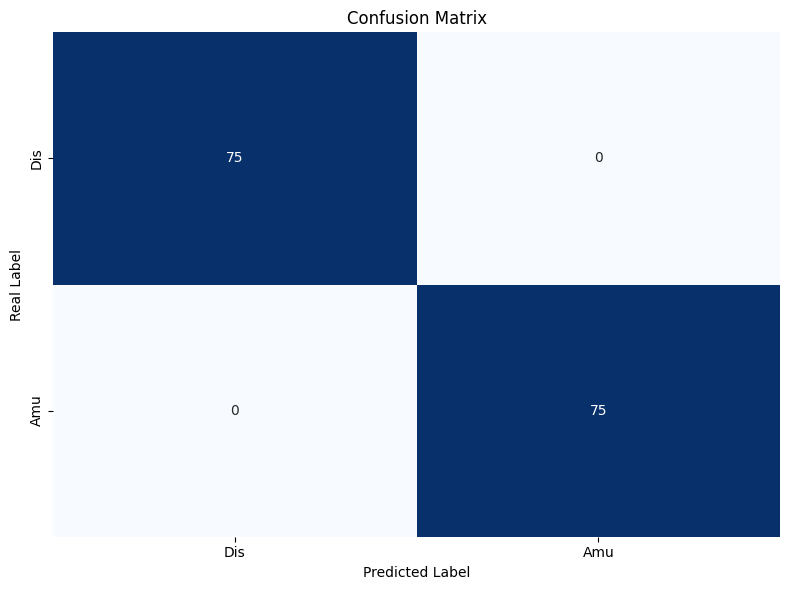

图表已保存为sub2_metrics_chart.png和sub2_confusion_matrix.png
分类器模型已保存至 /mnt/dataset0/xkp/closed-loop/server/data/sub2/emotion_classifier.pkl


<Figure size 1000x600 with 0 Axes>

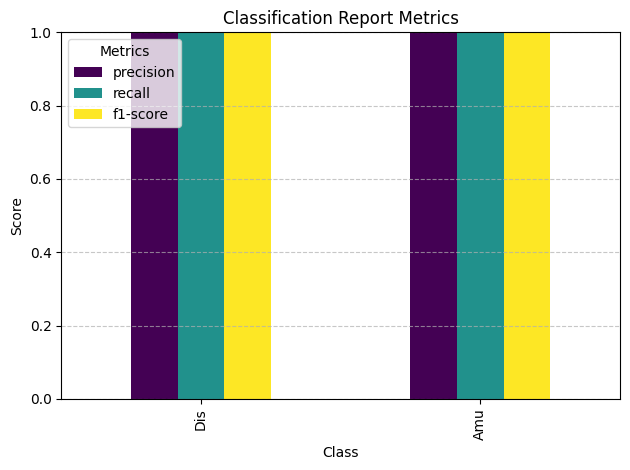

In [6]:
# 使用pandas生成报告并绘制图表
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 混淆矩阵可视化
cm = confusion_matrix(y_test, y_pred)
class_names = ['Dis', 'Amu']  # 根据你的标签类型调整
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Real Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'sub{subject_id}_confusion_matrix.png')
plt.show()

# 2. 性能指标条形图
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_metrics = df_report.iloc[:-3]
df_metrics = df_metrics.rename(index={'0': 'Dis', '1': 'Amu'})

metrics = ['precision', 'recall', 'f1-score']
df_plot = df_metrics[metrics]

plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', colormap='viridis')
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.xlabel('Class')
plt.ylim(0, 1.0)
plt.legend(title='Metrics', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'sub{subject_id}_metrics_chart.png')
print(f"图表已保存为sub{subject_id}_metrics_chart.png和sub{subject_id}_confusion_matrix.png")

# 保存模型用于后续实验
import pickle
model_save_path = os.path.join(base_data_path, 'emotion_classifier.pkl')
with open(model_save_path, 'wb') as f:
    pickle.dump(clf, f)
print(f"分类器模型已保存至 {model_save_path}")